# Shape descriptors based on neighborhood graphs
This notebook demonstrates how to determine shape descriptors of cells in case they cannot be segmented exactly but their centers can be detected.

In [1]:
import pyclesperanto_prototype as cle

print(cle.get_device())

<GeForce RTX 2080 Ti on Platform: NVIDIA CUDA (1 refs)>


We generate a label image of cells with given sizes in x and y and a size ratio of 1:1.5.

Assume this is the result of some cell segmentation algorithm.

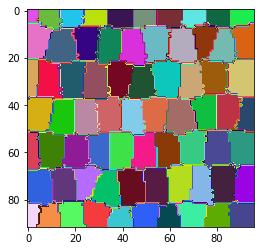

In [2]:
cell_size_x = 10
cell_size_y = 15

# generate and show tissue
tissue_labels = cle.artificial_tissue_2d(width=100, height=100, delta_x=cell_size_x, delta_y=cell_size_y, random_sigma_x=1, random_sigma_y=1)
cle.imshow(tissue_labels, labels=True)

# Classical shape descriptors: minor and major axis
We can measure the minor and major axis of those cells using scikit-image

In [3]:
from skimage.measure import regionprops
import numpy as np

label_image = cle.pull_zyx(tissue_labels).astype(int)

stats = regionprops(label_image)

avg_minor_axis_length = np.mean([s.minor_axis_length for s in stats])
print("Average minor axis length", avg_minor_axis_length)

avg_major_axis_length = np.mean([s.major_axis_length for s in stats])
print("Average major axis length", avg_major_axis_length)

Average minor axis length 10.636416711708394
Average major axis length 15.593910714260996


## Shape descriptors based on neighbor meshes
In some cases, we can't segment the cells properly, we can just do spot detection and visulize the centers of the cells.

Assume this is the result of a cell detection algorithm.

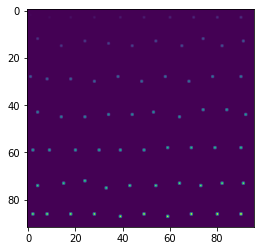

In [4]:
centroids = cle.centroids_of_labels(tissue_labels)

spot_image = cle.create_like(tissue_labels)
cle.pointlist_to_labelled_spots(centroids, spot_image)

cle.imshow(spot_image)

From such an image of labelled spots, we can make a voronoi diagram, were we can analyse wich cells (expanded spots) are close by each other.

The result is an approximation of cell segmentation.

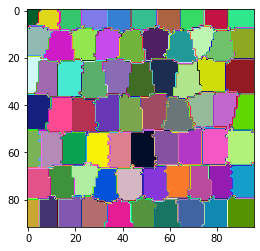

In [5]:
voronoi_diagram = cle.extend_labeling_via_voronoi(spot_image)

cle.imshow(voronoi_diagram, labels=True)

From such a pair of spots-image and voronoi diagram, we can dermine to matrices, a touch-matrix (also known as adjaceny-graph matrix) and a distance matrix.

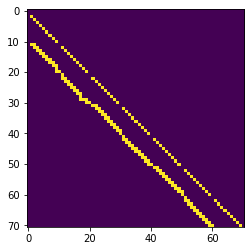

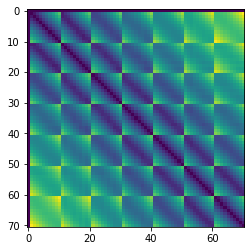

In [6]:
touch_matrix = cle.generate_touch_matrix(voronoi_diagram)

centroids = cle.labelled_spots_to_pointlist(spot_image) # this is susbstanially faster than centroids_of_labels

distance_matrix = cle.generate_distance_matrix(centroids, centroids)


cle.imshow(touch_matrix)
cle.imshow(distance_matrix)

From these two matrices, we can determine the minimum and maximum distance between centroids of touching objects (cells) in the voronoi image. These are estimated minor and major axis of the segmented objects.

In [9]:
min_distance = cle.minimum_distance_of_touching_neighbors(distance_matrix, touch_matrix)
max_distance = cle.maximum_distance_of_touching_neighbors(distance_matrix, touch_matrix)

print("minimum distance of touching neihbors", cle.mean_of_all_pixels(min_distance))
print("maximum distance of touching neihbors", cle.mean_of_all_pixels(max_distance))

minimum distance of touching neihbors 9.35331962477993
maximum distance of touching neihbors 15.501174282020246


## Distance visualisation
Finally, let's visualize distances between neighbors in a colored mesh.

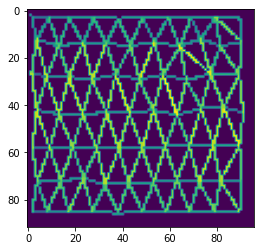

In [10]:
mesh = cle.draw_distance_mesh_between_touching_labels(voronoi_diagram)
cle.imshow(mesh)